In [1]:
from transformers import BertTokenizer
from process_childes import *
from sklearn.model_selection import train_test_split
import random
import pprint
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import Dataset
import torch

In [16]:
tokenizer = BertTokenizer.from_pretrained("ckiplab/bert-base-chinese")
data = clean_chinese_utterances_simple(extract_utterances_by_age_and_adult_folder("Mandarin"))

In [17]:

# Ages as integers
target_ages = [2, 3, 4, 5, 6]

# Select data for ages 2-6 and adults
selected_data = {age: data["child"].get(age, []) for age in target_ages}
selected_data["adult"] = data["adult"]

# Calculate sizes of each group
group_sizes = {group: len(utterances) for group, utterances in selected_data.items()}

# Find the smallest group size for balanced sampling
n_min = min(group_sizes.values())

# Pretty-print sizes and explanation
print(f"The smallest group size (n_min) among ages 2-6 and adults is: {n_min}\n")
print("Number of utterances per group (before sampling):")
pprint.pprint(group_sizes)
print("\nWe will sample", n_min,
      "utterances from each group to balance the dataset for fine-tuning.")
print("Then split each sampled group’s data into 80% train and 20% test.\n")

# Create balanced train/test splits
train_data = {}
test_data = {}

for group, utterances in selected_data.items():
    sampled = random.sample(utterances, n_min)
    train, test = train_test_split(sampled, test_size=0.2, random_state=42)
    train_data[group] = train
    test_data[group] = test

# Example: print train/test sizes per group
print("Train/test sizes per group after split:")
for group in train_data:
    print(f"  {group}: train={len(train_data[group])}, test={len(test_data[group])}")

The smallest group size (n_min) among ages 2-6 and adults is: 26872

Number of utterances per group (before sampling):
{2: 26872, 3: 45354, 4: 43809, 5: 53568, 6: 29654, 'adult': 348970}

We will sample 26872 utterances from each group to balance the dataset for fine-tuning.
Then split each sampled group’s data into 80% train and 20% test.

Train/test sizes per group after split:
  2: train=21497, test=5375
  3: train=21497, test=5375
  4: train=21497, test=5375
  5: train=21497, test=5375
  6: train=21497, test=5375
  adult: train=21497, test=5375


In [18]:
import json

data_to_save = {
    "train": train_data,
    "test": test_data
}

with open("balanced_train_test_data.json", "w", encoding="utf-8") as f:
    json.dump(data_to_save, f, ensure_ascii=False, indent=2)


In [10]:
import json

# Load JSON
with open("balanced_train_test_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Access train/test splits
train_data_loaded = data["train"]
test_data_loaded = data["test"]

# Example: print number of utterances for age 2 in train and test
print("Age 2 train utterances:", len(train_data_loaded["2"]))
print("Age 2 test utterances:", len(test_data_loaded["2"]))

# Access actual utterances, e.g. first train utterance for adults
print("First adult train utterance:", train_data_loaded["adult"][0])


Age 2 train utterances: 21497
Age 2 test utterances: 5375
First adult train utterance: 還 這麼 大力 用 我


In [20]:
# 1. Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("ckiplab/bert-base-chinese")
model = BertForMaskedLM.from_pretrained("ckiplab/bert-base-chinese")

def finetune_on_group(age, train_data, test_data):
    print(f"Starting fine-tuning for group: {age}")

    # 1. Load tokenizer and base model
    tokenizer = BertTokenizer.from_pretrained("ckiplab/bert-base-chinese")
    model = BertForMaskedLM.from_pretrained("ckiplab/bert-base-chinese")

    # 2. Select group-specific texts
    train_texts = train_data[age]
    test_texts = test_data[age]

    # 3. Tokenize
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    train_dataset = Dataset.from_dict({"text": train_texts})
    test_dataset = Dataset.from_dict({"text": test_texts})
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)
    train_dataset = train_dataset.remove_columns(["text"])
    test_dataset = test_dataset.remove_columns(["text"])
    train_dataset.set_format("torch")
    test_dataset.set_format("torch")

    # 4. Data collator for MLM
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=True, mlm_probability=0.15
    )

    # 5. Training args
    training_args = TrainingArguments(
        output_dir=f"./bert-finetuned-childes-{age}",
        overwrite_output_dir=True,
        num_train_epochs=2,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        save_strategy="epoch",
        logging_dir=f"./logs-{age}",
        logging_steps=2000,
        learning_rate=5e-5,
        weight_decay=0.01,
        save_total_limit=1,
        seed=42,
        report_to=None,
    )

    # 6. Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=data_collator,
    )

    # 7. Train
    trainer.train()
    trainer.save_model()
    tokenizer.save_pretrained(training_args.output_dir)
    print(f"Finished fine-tuning for group: {age}")

In [28]:
finetune_on_group(3, train_data, test_data)

Starting fine-tuning for group: 3


Map:   0%|          | 0/21497 [00:00<?, ? examples/s]

Map:   0%|          | 0/5375 [00:00<?, ? examples/s]

/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
2000,3.274900
4000,3.063600
6000,2.757100
8000,2.566600
10000,2.351200


/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Finished fine-tuning for group: 3


In [29]:
finetune_on_group(4, train_data, test_data)
finetune_on_group(5, train_data, test_data)
finetune_on_group(6, train_data, test_data)
finetune_on_group('adult', train_data, test_data)

Starting fine-tuning for group: 4


Map:   0%|          | 0/21497 [00:00<?, ? examples/s]

Map:   0%|          | 0/5375 [00:00<?, ? examples/s]

/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
2000,3.117800
4000,2.742300
6000,2.542700
8000,2.385000
10000,2.251600


/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Finished fine-tuning for group: 4
Starting fine-tuning for group: 5


Map:   0%|          | 0/21497 [00:00<?, ? examples/s]

Map:   0%|          | 0/5375 [00:00<?, ? examples/s]

/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
2000,2.875500
4000,2.567000
6000,2.429400
8000,2.208300
10000,2.127300


/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Finished fine-tuning for group: 5
Starting fine-tuning for group: 6


Map:   0%|          | 0/21497 [00:00<?, ? examples/s]

Map:   0%|          | 0/5375 [00:00<?, ? examples/s]

/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
2000,2.584000
4000,2.248700
6000,2.049700
8000,1.903000
10000,1.818500


/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Finished fine-tuning for group: 6
Starting fine-tuning for group: adult


Map:   0%|          | 0/21497 [00:00<?, ? examples/s]

Map:   0%|          | 0/5375 [00:00<?, ? examples/s]

/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
2000,2.788200
4000,2.544400
6000,2.382500
8000,2.188700
10000,2.019500


/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Finished fine-tuning for group: adult


In [24]:
from transformers import BertModel, BertTokenizerFast
import torch


# Path to fine-tuned model for age 2
model_path = "./bert-finetuned-childes-2"

# Load tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained("ckiplab/bert-base-chinese")
model = BertModel.from_pretrained("./bert-finetuned-childes-2")
model.eval()

# Example sentences from test data for age 2
examples = [s for s in test_data[2] if any(c in s for c in ["把", "被", "給"])][:5]

for sentence in examples:
    print(f"\nSentence: {sentence}")
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state  # [1, seq_len, hidden_size]

    for token, embedding in zip(tokenizer.tokenize(sentence), last_hidden[0]):
        if token in ["把", "被", "給"]:
            print(f"Token: {token}, Embedding (first 5 dims): {embedding[:5].numpy()}")


Some weights of BertModel were not initialized from the model checkpoint at ./bert-finetuned-childes-2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Sentence: 媽 這 給 你 裝 糖糖
Token: 給, Embedding (first 5 dims): [ 0.3831836   0.14854342  1.0518594   0.51030314 -0.25015423]

Sentence: 給 你
Token: 給, Embedding (first 5 dims): [ 0.47552234  1.3585104  -0.17690827  1.0646026   0.09977802]

Sentence: 我 今天 要 給 大家
Token: 給, Embedding (first 5 dims): [ 0.5919233  -0.00127056 -0.7923497   0.68201035 -0.04552491]

Sentence: 我 也 要 給 小 牛 洗澡
Token: 給, Embedding (first 5 dims): [ 0.7196787  -0.04465713 -0.7582121   0.5101793  -0.14212166]

Sentence: 那 你 把 這 個 橫 寫 完
Token: 把, Embedding (first 5 dims): [ 1.0561988  -0.02080734 -0.95447844  0.59562993  0.59436715]


In [25]:
import numpy as np
from transformers import BertModel, BertTokenizerFast
import torch
import os

model_path = "./bert-finetuned-childes-2"
target_chars = ["把", "被", "給"]

# Load tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained("ckiplab/bert-base-chinese")
model = BertModel.from_pretrained(model_path)
model.eval()

embeddings_dict = {char: [] for char in target_chars}

for sentence in test_data[2]:
    if any(char in sentence for char in target_chars):
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state[0]  # [seq_len, hidden_size]

        tokens = tokenizer.tokenize(sentence)
        for idx, token in enumerate(tokens):
            if token in target_chars:
                emb = last_hidden[idx].cpu().numpy()
                embeddings_dict[token].append({
                    "sentence": sentence,
                    "token_index": idx,
                    "embedding": emb
                })

# Save embeddings as npz file (change path if needed)
os.makedirs("embeddings_age2", exist_ok=True)
for char, entries in embeddings_dict.items():
    # Save embeddings and sentences separately
    embs = np.array([e["embedding"] for e in entries])
    sentences = [e["sentence"] for e in entries]
    np.savez_compressed(f"embeddings_age2/{char}_embeddings.npz", embeddings=embs, sentences=sentences)


Some weights of BertModel were not initialized from the model checkpoint at ./bert-finetuned-childes-2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


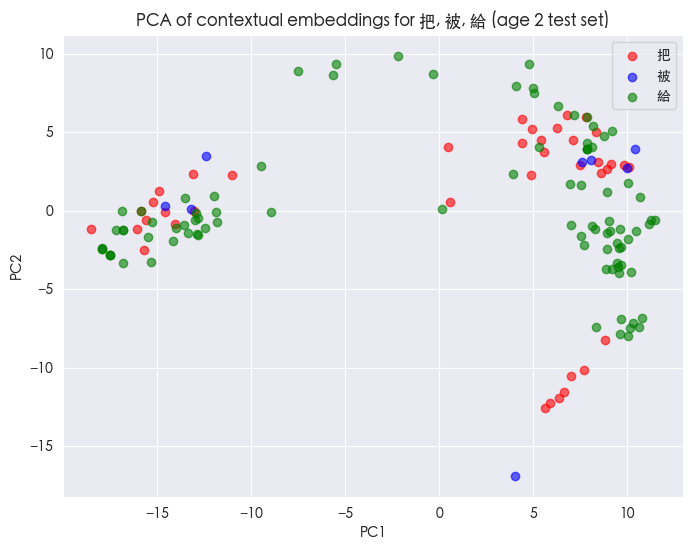

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib import font_manager

# Font for Chinese
font_path = "/System/Library/Fonts/STHeiti Medium.ttc"  # adjust for your OS
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

chars = ["把", "被", "給"]
colors = {"把": "red", "被": "blue", "給": "green"}

plt.figure(figsize=(8, 6))

for char in chars:
    data = np.load(f"embeddings_age2/{char}_embeddings.npz", allow_pickle=True)
    embs = data["embeddings"]

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embs)

    plt.scatter(reduced[:, 0], reduced[:, 1], label=char, alpha=0.6, color=colors[char])

plt.title("PCA of contextual embeddings for 把, 被, 給 (age 2 test set)")
plt.legend(prop=font_prop)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [6]:
import numpy as np
from transformers import BertModel, BertTokenizerFast
import torch
import os

def extract_embeddings_for_age(sentences, age):
    target_chars = ["把", "被", "給"]
    model_path = f"./bert-finetuned-childes-{age}"

    # Load tokenizer and model
    tokenizer = BertTokenizerFast.from_pretrained("ckiplab/bert-base-chinese")
    model = BertModel.from_pretrained(model_path)
    model.eval()

    embeddings_dict = {char: [] for char in target_chars}

    for sentence in sentences:
        if any(char in sentence for char in target_chars):
            inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=128)
            with torch.no_grad():
                outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state[0]  # [seq_len, hidden_size]

            tokens = tokenizer.tokenize(sentence)
            for idx, token in enumerate(tokens):
                if token in target_chars:
                    emb = last_hidden[idx].cpu().numpy()
                    embeddings_dict[token].append({
                        "sentence": sentence,
                        "token_index": idx,
                        "embedding": emb
                    })

    # Save embeddings
    save_dir = f"embeddings_age{age}"
    os.makedirs(save_dir, exist_ok=True)
    for char, entries in embeddings_dict.items():
        embs = np.array([e["embedding"] for e in entries])
        sentences = [e["sentence"] for e in entries]
        np.savez_compressed(f"{save_dir}/{char}_embeddings.npz", embeddings=embs, sentences=sentences)


In [14]:
extract_embeddings_for_age(test_data_loaded['2'], 2)
extract_embeddings_for_age(test_data_loaded['3'], 3)
extract_embeddings_for_age(test_data_loaded['4'], 4)
extract_embeddings_for_age(test_data_loaded['5'], 5)
extract_embeddings_for_age(test_data_loaded['6'], 6)
extract_embeddings_for_age(test_data_loaded['adult'], "adult")


Some weights of BertModel were not initialized from the model checkpoint at ./bert-finetuned-childes-2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/Work/PycharmProjects/embeddings/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Some weights of BertModel were not initialized from the model checkpoint at ./bert-finetuned-childes-3 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at ./bert-finetuned-childes-4 and are newly initialized: ['pooler.dense.bias', '

In [12]:
test_data_loaded.keys()

dict_keys(['2', '3', '4', '5', '6', 'adult'])

In [18]:
data = np.load(f"embeddings_age2/被_embeddings.npz", allow_pickle=True)
print(data["embeddings"].shape)


(8, 768)
